# Titanic survival prediction challenge - Kaggle

#### Data obtained from https://www.kaggle.com/c/titanic
#### *October 2022*
#### By Irem Arici

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("train.csv")

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### sibsp and parch denotes siblings/spouse and parent in the ship

#### embarked denotes the port of embarkation

In [4]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Correlations with the survival?

In [5]:
import seaborn as sns

<function matplotlib.pyplot.show(close=None, block=None)>

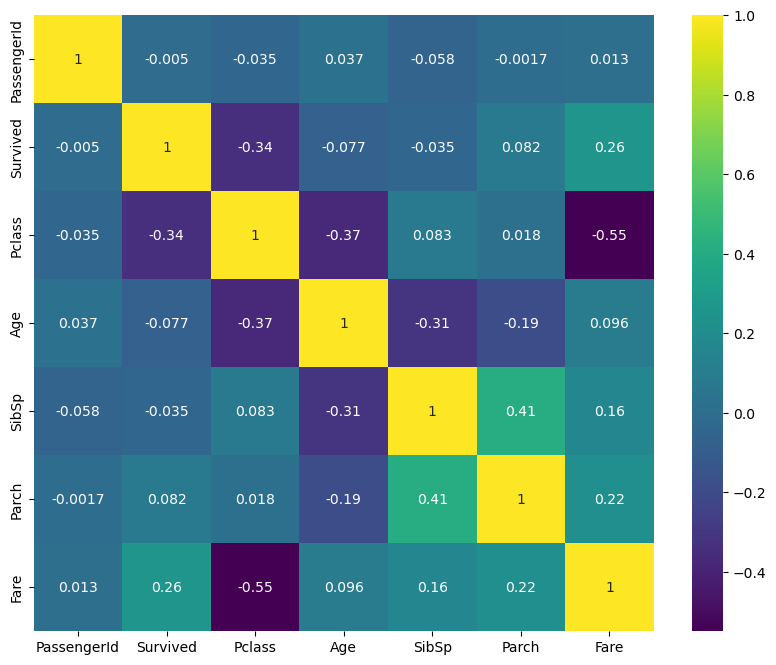

In [6]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(data.corr(numeric_only=True), cmap="viridis", annot=True)
plt.show

pclass & fare variables are negatively correlated

stratified shuffle split for random split:

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

In [9]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(data,data[["Survived", "Pclass", "Sex"]]):
    strat_train_set = data.loc[train_indices]
    strat_test_set = data.loc[test_indices]

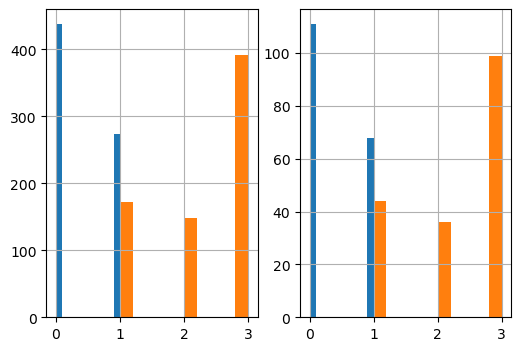

In [10]:
plt.figure(figsize=(6,4))

plt.subplot(1,2,1)
strat_train_set["Survived"].hist() #blue bars
strat_train_set["Pclass"].hist()   #orange bars

plt.subplot(1,2,2)
strat_test_set["Survived"].hist()
strat_test_set["Pclass"].hist()

plt.show()

In [11]:
strat_train_set.info() # age & cabin info is missing for a lot of people

# dropping cabin column for that reason

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 652 to 139
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          571 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        153 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


## **Use imputer to hande missing values**

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

In [20]:
class AgeImputer (BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform (self, X):
        imputer = SimpleImputer(strategy = "mean")
        X["Age"] = imputer.fit_transform(X[["Age"]])
        return X

## **One hot encoding**

In [21]:
from sklearn.preprocessing import OneHotEncoder

In [22]:
class FeatureEncoder(BaseEstimator,TransformerMixin):
    
    def fit(self, X, y = None):
        return self
    
    def transform(self,X):
        #Embarked
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[["Embarked"]]).toarray()
        
        column_names = ["C", "S", "Q", "N"] 
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        #Sex   
        matrix = encoder.fit_transform(X[["Sex"]]).toarray()
        
        column_names = ["Female", "Male"]
        
        for i in range(len(matrix.T)):
            X[column_names[i]] = matrix.T[i]
        
        return X

## **Dropping some columns**

In [23]:
class FeatureDropper(BaseEstimator,TransformerMixin):
    
    def fit(self, X, y = None):
        return self
    
    def transform(self,X):
        return X.drop(["Embarked", "Name", "Ticket", "Cabin", "Sex", "N"], axis = 1, errors="ignore")

## **Creating pipeline**

In [24]:
from sklearn.pipeline import Pipeline

In [25]:
pipeline = Pipeline([("ageimputer",AgeImputer()),
                    ("featureencoder", FeatureEncoder()),
                    ("featuredropper", FeatureDropper())])

## **Fitting the set to pipeline**

In [26]:
strat_train_set = pipeline.fit_transform(strat_train_set)

#### *Let's see what it looks like...*

In [27]:
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
652,653,0,3,21.0,0,0,8.4333,0.0,0.0,1.0,0.0,1.0
52,53,1,1,49.0,1,0,76.7292,1.0,0.0,0.0,1.0,0.0
242,243,0,2,29.0,0,0,10.5000,0.0,0.0,1.0,0.0,1.0
824,825,0,3,2.0,4,1,39.6875,0.0,0.0,1.0,0.0,1.0
698,699,0,1,49.0,1,1,110.8833,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
339,340,0,1,45.0,0,0,35.5000,0.0,0.0,1.0,0.0,1.0
271,272,1,3,25.0,0,0,0.0000,0.0,0.0,1.0,0.0,1.0
528,529,0,3,39.0,0,0,7.9250,0.0,0.0,1.0,0.0,1.0
331,332,0,1,45.5,0,0,28.5000,0.0,0.0,1.0,0.0,1.0


In [28]:
strat_train_set.info() # no NaN for Age

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 652 to 139
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


# Training model

In [29]:
from sklearn.preprocessing import StandardScaler

In [30]:
scaler = StandardScaler()

In [31]:
X = strat_train_set.drop(["Survived"], axis=1,errors = "ignore")
y = strat_train_set["Survived"]

X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

# **Random forest classifier**

In [35]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV # for cross-validation & most optimal hyperparameters

In [33]:
classifier = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 100, 200, 500], "max_depth":[None, 5, 10],
    "min_samples_split": [2, 3, 4]}
]

grid_search = GridSearchCV(classifier, param_grid, cv = 3, scoring= "accuracy",
                          return_train_score=True)
grid_search.fit(X_data,y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [34]:
final_classifier = grid_search.best_estimator_

In [36]:
final_classifier #n_estimator is 200, max_depth is 5

RandomForestClassifier(min_samples_split=4, n_estimators=500)

# **Test set**

In [37]:
strat_test_set = pipeline.fit_transform(strat_test_set)

In [38]:
strat_test_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
590,591,0,3,35.000000,0,0,7.1250,0.0,0.0,1.0,0.0,1.0
68,69,1,3,17.000000,4,2,7.9250,0.0,0.0,1.0,1.0,0.0
336,337,0,1,29.000000,1,0,66.6000,0.0,0.0,1.0,0.0,1.0
43,44,1,2,3.000000,1,2,41.5792,1.0,0.0,0.0,1.0,0.0
196,197,0,3,29.992448,0,0,7.7500,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
675,676,0,3,18.000000,0,0,7.7750,0.0,0.0,1.0,0.0,1.0
544,545,0,1,50.000000,1,0,106.4250,1.0,0.0,0.0,0.0,1.0
703,704,0,3,25.000000,0,0,7.7417,0.0,1.0,0.0,0.0,1.0
232,233,0,2,59.000000,0,0,13.5000,0.0,0.0,1.0,0.0,1.0


In [42]:
X_test = strat_test_set.drop(["Survived"], axis = 1)
y_test = strat_test_set["Survived"]

scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [43]:
final_classifier.score(X_data_test, y_data_test)

0.8324022346368715

In [45]:
final_data = pipeline.fit_transform(data)

In [46]:
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [48]:
X_final = final_data.drop(["Survived"], axis = 1)
y_final = final_data["Survived"]

scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

## Running grid search again on the whole dataset

In [49]:
production_classifier = RandomForestClassifier()

param_grid = [
    {"n_estimators": [10, 100, 200, 500], "max_depth":[None, 5, 10],
    "min_samples_split": [2, 3, 4]}
]

grid_search = GridSearchCV(production_classifier, param_grid, cv = 3, scoring= "accuracy",
                          return_train_score=True)
grid_search.fit(X_data_final, y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [50]:
production_classifier_final = grid_search.best_estimator_

In [52]:
production_classifier_final # max_depth=5, min_samples_split=4, n_estimators=200

RandomForestClassifier(max_depth=5, min_samples_split=4, n_estimators=200)

In [53]:
titanic_test_data = pd.read_csv("test.csv")

In [55]:
final_test_data = pipeline.fit_transform(titanic_test_data)

In [59]:
final_test_data.info() # null value in Fare

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         417 non-null    float64
 6   C            418 non-null    float64
 7   S            418 non-null    float64
 8   Q            418 non-null    float64
 9   Female       418 non-null    float64
 10  Male         418 non-null    float64
dtypes: float64(7), int64(4)
memory usage: 36.0 KB


In [63]:
X_final_test = final_test_data
X_final_test = X_final_test.ffill() # instead of fillna.(method = "ffill")

scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

In [64]:
predictions = production_classifier_final.predict(X_data_final_test)

In [66]:
final_df = pd.DataFrame(titanic_test_data["PassengerId"])
final_df["Survived"] = predictions
final_df.to_csv("predictions.csv", index= False)